# Figures for Yeager et al., 2025: Efficient Drift Correction of Initialized Earth System Predictions
### CESM2-SMYLE and E3SMv2.1-SMYLE precipitation analysis

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
import nc_time_axis
%matplotlib inline

# import plotting and other utilities
# https://github.com/sgyeager/mypyutils
from mypyutils import calendar_utils as cal
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import regrid_utils as regrid
from mypyutils import io_utils as io
from mypyutils import stat_utils as stat

## Dask

### Create Dask Cluster

In [45]:
try:
    client.shutdown()
except:
    pass

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='32GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=32GB',
        account='P06010014',
        walltime='02:30:00',
        local_directory='/glade/derecho/scratch/yeager/',
        log_directory='/glade/derecho/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": 1.0,
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(50) 
client

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36135 instead
  warnings.warn(


<Client: 'tcp://128.117.208.180:42785' processes=0 threads=0, memory=0 B>

### Read in CESM2-SMYLE PRE monthly data

In [3]:
datadir = '/glade/derecho/scratch/yeager/YeagerEA_EffDriftCorr/data/'

In [4]:
cesm_smyle11 = xr.open_dataset(datadir+'CESM2-SMYLE_NOV.PRE.1970-2020.nc').chunk({'M':1})
cesm_smyle11['PRE'] = cesm_smyle11['PRE'].astype('float32')

In [5]:
cesm_smyle11_climoic = xr.open_dataset(datadir+'CESM2-SMYLE_NOV.PRE.climoIC.nc').chunk({'M':1})
cesm_smyle11_climoic['PRE'] = cesm_smyle11_climoic['PRE'].astype('float32')

### Read in E3SM2-SMYLE PRE monthly data

In [6]:
e3sm_smyle11 = xr.open_dataset(datadir+'E3SMv2.1-SMYLE_NOV.PRE.1970-2020.nc').chunk({'M':1})
e3sm_smyle11['PRE'] = e3sm_smyle11['PRE'].astype('float32')

In [7]:
e3sm_smyle11_climoic = xr.open_dataset(datadir+'E3SMv2.1-SMYLE_NOV.PRE.climoIC.nc').chunk({'M':1})
e3sm_smyle11_climoic['PRE'] = e3sm_smyle11_climoic['PRE'].astype('float32')

### Observed PRE

In [8]:
gpcp = xr.open_dataset(datadir+'GPCPv2.3.PRE.1979-2023.fv09.nc').astype('float32')

## Obs monthly anomalies

In [9]:
climy0 = 1991
climy1 = 2020

In [10]:
def monthly_anomaly(da, y0, y1, output='anomaly', groupby_type="time.month"):
    gb = da.groupby(groupby_type)
    clim = da.sel(time=slice(str(y0),str(y1))).groupby(groupby_type).mean(dim="time")
    anom = gb - clim
    if output=='anomaly':
        da_out = anom
    else:
        da_out = clim
    return da_out

In [11]:
%%time
obs_mon_clim = monthly_anomaly(gpcp['PRE'],climy0,climy1,'clim').compute()
obs_mon_anom = gpcp['PRE'].map_blocks(monthly_anomaly, args=[climy0,climy1,'anomaly'], template=gpcp['PRE']).compute()

CPU times: user 128 ms, sys: 63.8 ms, total: 192 ms
Wall time: 220 ms


### De-drift (using various methods)

In [12]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1991
climy1 = 2020
cesm_smyle11_time = cesm_smyle11.time.load()
cesm_smyle11_anom_meth2,cesm_smyle11_clim = stat.remove_drift(cesm_smyle11['PRE'],cesm_smyle11_time,climy0,climy1)

CPU times: user 2.26 s, sys: 135 ms, total: 2.4 s
Wall time: 20.6 s


In [13]:
%%time
# Method 2, but only 1 member
iterations = 100
cesm_smyle11_anom_meth2_1mem,cesm_smyle11_clim_1mem = stat.remove_drift_nmem(cesm_smyle11['PRE'].drop_vars('M'),cesm_smyle11_time,climy0,climy1,1,iterations)

CPU times: user 6.95 s, sys: 356 μs, total: 6.95 s
Wall time: 7.42 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [14]:
%%time
# Method 2, but only 3 member
iterations = 100
cesm_smyle11_anom_meth2_3mem,cesm_smyle11_clim_3mem = stat.remove_drift_nmem(cesm_smyle11['PRE'].drop_vars('M'),cesm_smyle11_time,climy0,climy1,3,iterations)

CPU times: user 7.74 s, sys: 242 μs, total: 7.74 s
Wall time: 8.51 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [15]:
## Use Method 3 to compute anomalies (subtract climoIC ensemble):
cesm_smyle11_anom_meth3 = cesm_smyle11['PRE'] - cesm_smyle11_climoic['PRE'].mean('M').squeeze()

In [16]:
## Use Method 1 to compute anomalies (subtract observed climo):
obs_climo = cesm_smyle11_climoic['PRE'].mean('M').squeeze().copy()
mons = cesm_smyle11_time.sel(Y=2005).dt.month.values
for i in range(24):
    thismonth=mons[i]
    obs_climo.loc[dict(L=(i+1))] = obs_mon_clim.sel(month=thismonth)
obs_climo = obs_climo.load()
cesm_smyle11_anom_meth1 = cesm_smyle11['PRE'] - obs_climo

In [17]:
## rechunk
e3sm_smyle11 = e3sm_smyle11.chunk({'Y':1})

In [19]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1991
climy1 = 2020
e3sm_smyle11_time = e3sm_smyle11.time.load()
e3sm_smyle11_anom_meth2,e3sm_smyle11_clim = stat.remove_drift(e3sm_smyle11['PRE'],e3sm_smyle11_time,climy0,climy1)

CPU times: user 56 ms, sys: 2.86 ms, total: 58.9 ms
Wall time: 218 ms


In [20]:
%%time
# Method 2, but only 1 member
iterations = 100
e3sm_smyle11_anom_meth2_1mem,e3sm_smyle11_clim_1mem = stat.remove_drift_nmem(e3sm_smyle11['PRE'].drop_vars('M'),e3sm_smyle11_time,climy0,climy1,1,iterations)

CPU times: user 7.54 s, sys: 16 ms, total: 7.56 s
Wall time: 8.18 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 100
  result = blockwise(


In [21]:
%%time
# Method 2, but only 3 member
iterations = 100
e3sm_smyle11_anom_meth2_3mem,e3sm_smyle11_clim_3mem = stat.remove_drift_nmem(e3sm_smyle11['PRE'].drop_vars('M'),e3sm_smyle11_time,climy0,climy1,3,iterations)

CPU times: user 7.99 s, sys: 26 ms, total: 8.02 s
Wall time: 8.64 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 100
  result = blockwise(


In [22]:
# Use Method 3 to compute anomalies (subtract climoIC ensemble):
e3sm_smyle11_anom_meth3 = e3sm_smyle11['PRE'] - e3sm_smyle11_climoic['PRE'].mean('M').squeeze()

In [23]:
## Use Method 1 to compute anomalies (subtract observed climo):
e3sm_smyle11_anom_meth1 = e3sm_smyle11['PRE'] - obs_climo

## Latlon Bias Comparison Plot

In [24]:
lon = cesm_smyle11.lon
lat = cesm_smyle11.lat

In [25]:
%%time
cesm_climobias2 = cesm_smyle11_clim - obs_climo
cesm_climobias2 = cesm_climobias2.load()

CPU times: user 2.65 s, sys: 213 ms, total: 2.86 s
Wall time: 27.3 s


In [26]:
%%time
e3sm_climobias2 = e3sm_smyle11_clim - obs_climo
e3sm_climobias2 = e3sm_climobias2.load()

CPU times: user 3.38 s, sys: 170 ms, total: 3.55 s
Wall time: 19.9 s


In [27]:
%%time
cesm_climobias2_1mem = cesm_smyle11_clim_1mem - obs_climo

CPU times: user 8.64 ms, sys: 10 μs, total: 8.65 ms
Wall time: 8.68 ms


In [28]:
%%time
e3sm_climobias2_1mem = e3sm_smyle11_clim_1mem - obs_climo

CPU times: user 9.57 ms, sys: 180 μs, total: 9.75 ms
Wall time: 9.76 ms


In [29]:
%%time
cesm_climobias2_3mem = cesm_smyle11_clim_3mem - obs_climo
#cesm_climobias2_3mem = cesm_climobias2_3mem.load()

CPU times: user 13.2 ms, sys: 33 μs, total: 13.2 ms
Wall time: 13.3 ms


In [30]:
%%time
e3sm_climobias2_3mem = e3sm_smyle11_clim_3mem - obs_climo
#e3sm_climobias2_3mem = e3sm_climobias2_3mem.load()

CPU times: user 13 ms, sys: 16 μs, total: 13 ms
Wall time: 13.2 ms


In [31]:
%%time
cesm_climobias3 = cesm_smyle11_climoic['PRE'].mean('M').squeeze() - obs_climo
cesm_climobias3 = cesm_climobias3.load()

CPU times: user 195 ms, sys: 14.3 ms, total: 210 ms
Wall time: 1.14 s


In [32]:
%%time
e3sm_climobias3 = e3sm_smyle11_climoic['PRE'].mean('M').squeeze() - obs_climo
e3sm_climobias3 = e3sm_climobias3.load()

CPU times: user 124 ms, sys: 1.96 ms, total: 126 ms
Wall time: 672 ms


## Supplementary Figure 15

CPU times: user 50.8 s, sys: 103 ms, total: 50.9 s
Wall time: 55.4 s


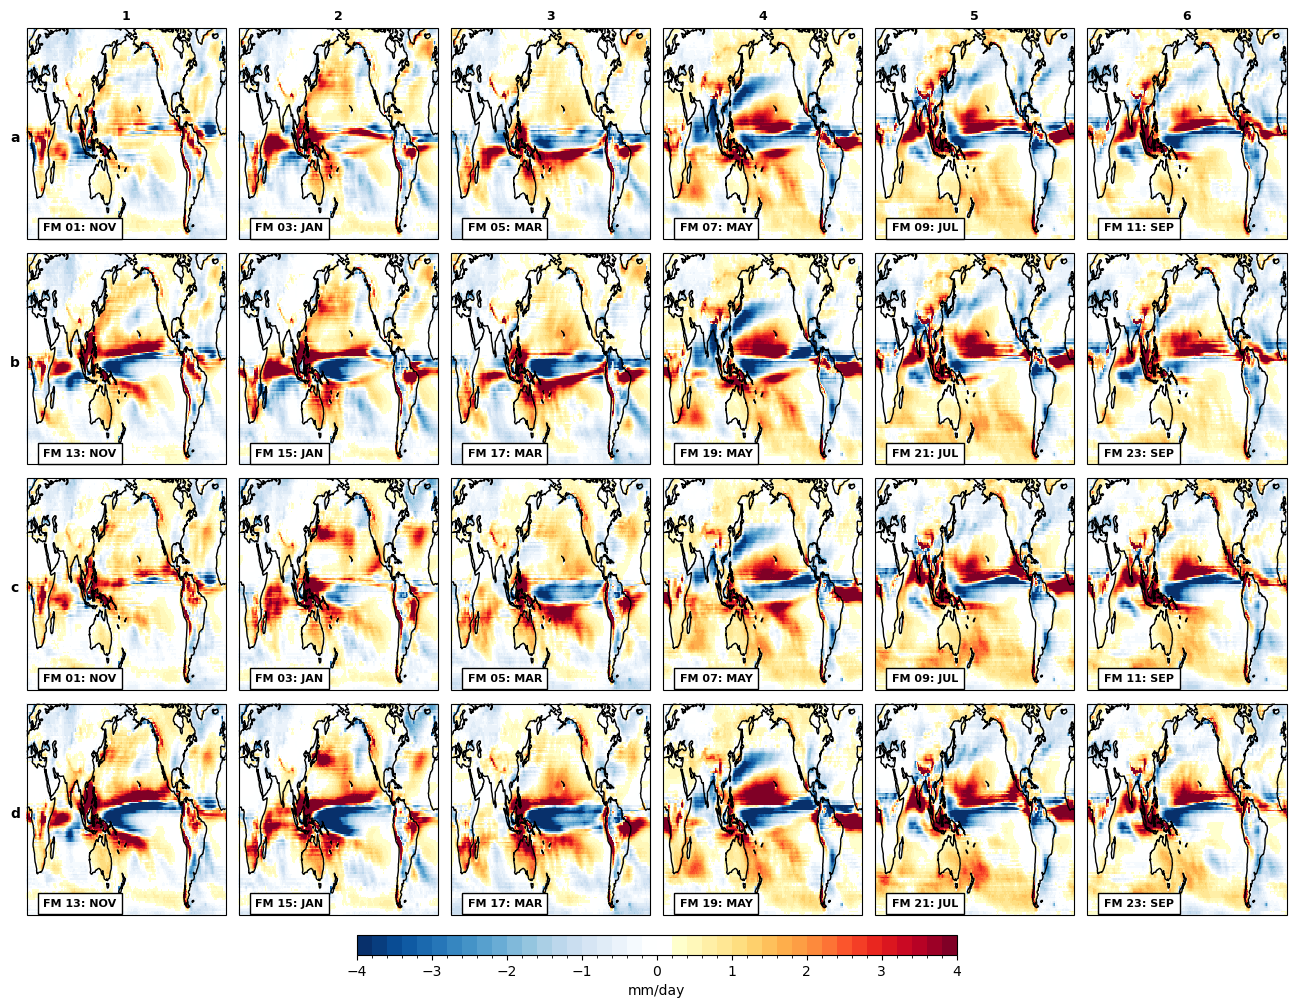

In [33]:
%%time
ci = 0.2
cmin = -4
cmax = 4

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, cesm_climobias2.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, e3sm_climobias2.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'mm/day', orientation='horizontal')

plt.savefig('Fig_supp15.png')

In [34]:
%%time
cesm_msss3 = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth3,cesm_smyle11_anom_meth2,nleads=23,resamp=0,detrend=False)
cesm_msss3 = cesm_msss3.load()

CPU times: user 5.67 s, sys: 366 ms, total: 6.04 s
Wall time: 27.5 s


In [35]:
%%time
cesm_msss1 = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth1,cesm_smyle11_anom_meth2,nleads=23,resamp=0,detrend=False)
cesm_msss1 = cesm_msss1.load()

CPU times: user 5.78 s, sys: 371 ms, total: 6.15 s
Wall time: 23.4 s


In [36]:
%%time
chunks = {'M':1,'Y':-1}
cesm_msss2_1mem = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth2_1mem.chunk(chunks),cesm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False)
cesm_msss2_1mem = cesm_msss2_1mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 15.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 8s, sys: 4.23 s, total: 2min 12s
Wall time: 2min 30s


In [37]:
%%time
chunks = {'M':1,'Y':-1}
cesm_msss2_3mem = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth2_3mem.chunk(chunks),cesm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False)
cesm_msss2_3mem = cesm_msss2_3mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 22.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 21s, sys: 7.77 s, total: 3min 28s
Wall time: 6min


In [38]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss1 = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth1.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss1 = e3sm_msss1.load()

CPU times: user 9.74 s, sys: 415 ms, total: 10.2 s
Wall time: 24.1 s


In [39]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss3 = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth3.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss3 = e3sm_msss3.load()

CPU times: user 8.15 s, sys: 438 ms, total: 8.59 s
Wall time: 22.7 s


In [40]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss2_1mem = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth2_1mem.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss2_1mem = e3sm_msss2_1mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 20.07 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 27s, sys: 7.21 s, total: 3min 34s
Wall time: 4min 46s


In [41]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss2_3mem = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth2_3mem.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss2_3mem = e3sm_msss2_3mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 26.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 43s, sys: 6.26 s, total: 3min 49s
Wall time: 4min 58s


## Supplementary Figure 16

CPU times: user 49.9 s, sys: 247 ms, total: 50.1 s
Wall time: 53.3 s


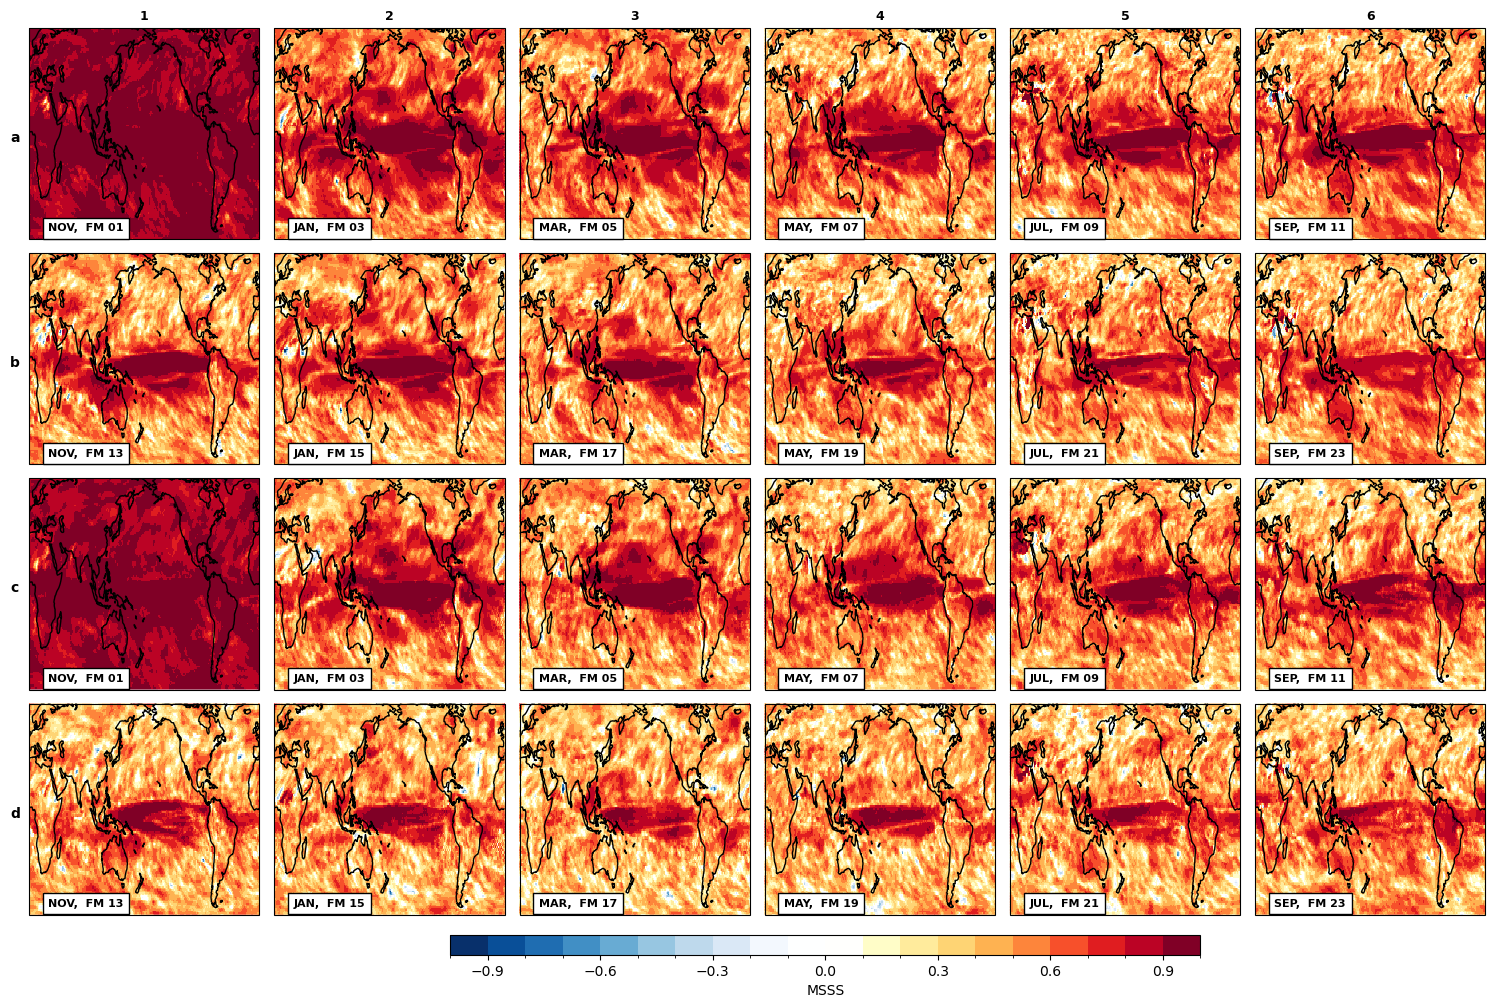

In [42]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss2_1mem['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss2_1mem['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp16.png')

## Supplementary Figure 17

CPU times: user 50.3 s, sys: 161 ms, total: 50.4 s
Wall time: 56.3 s


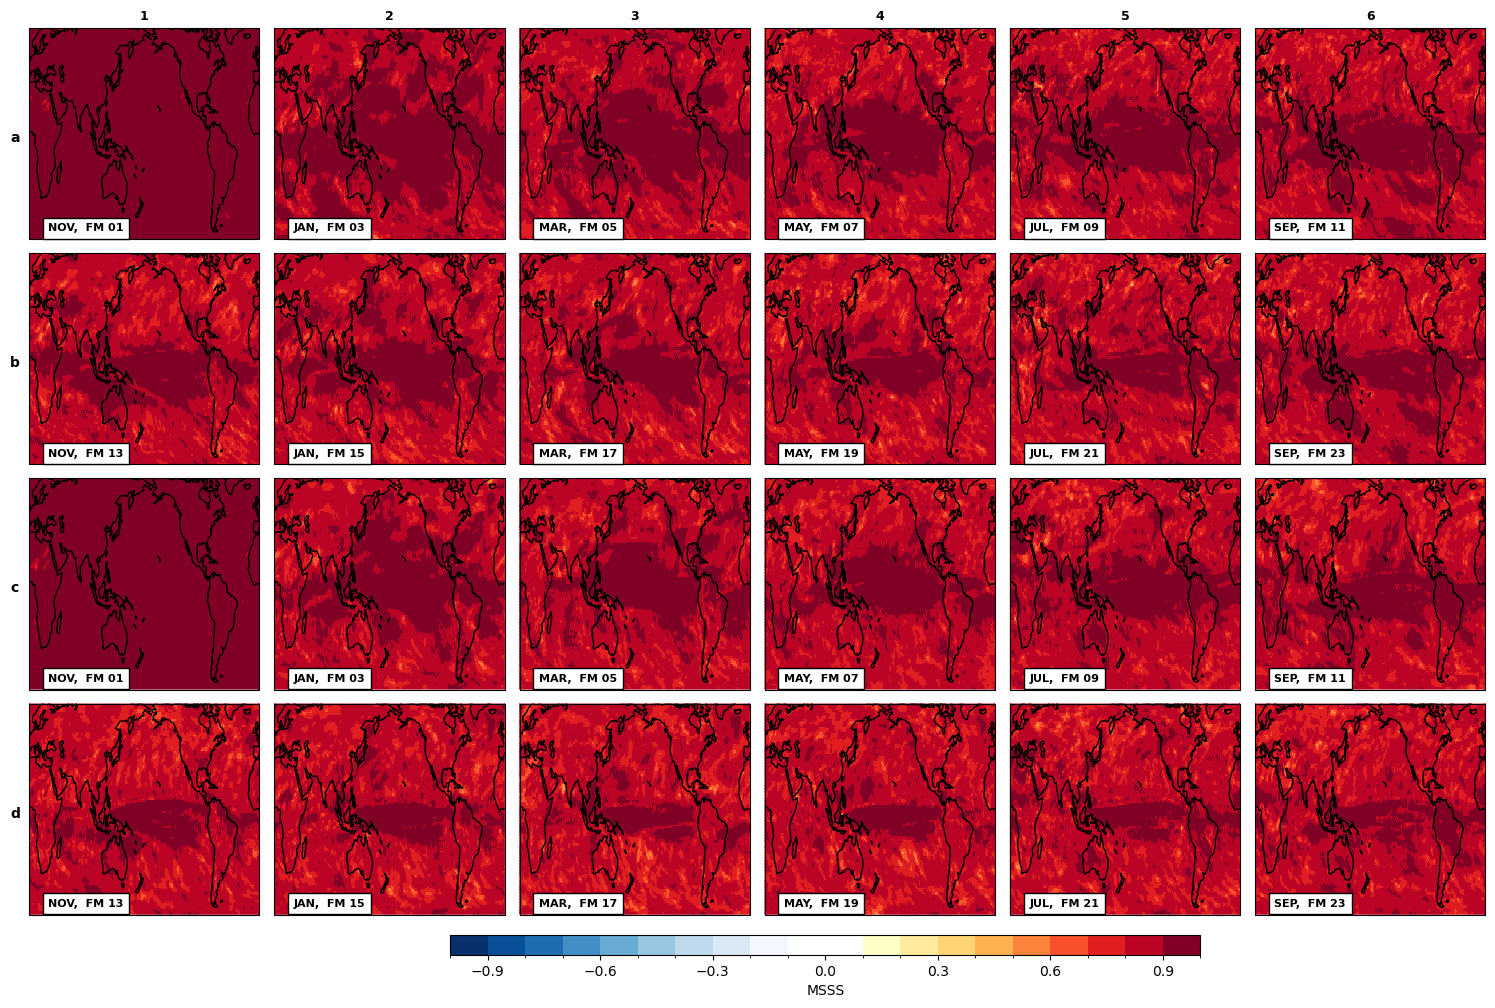

In [43]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss2_3mem['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss2_3mem['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp17.png')

## Supplementary Figure 18

CPU times: user 50.3 s, sys: 212 ms, total: 50.5 s
Wall time: 55.4 s


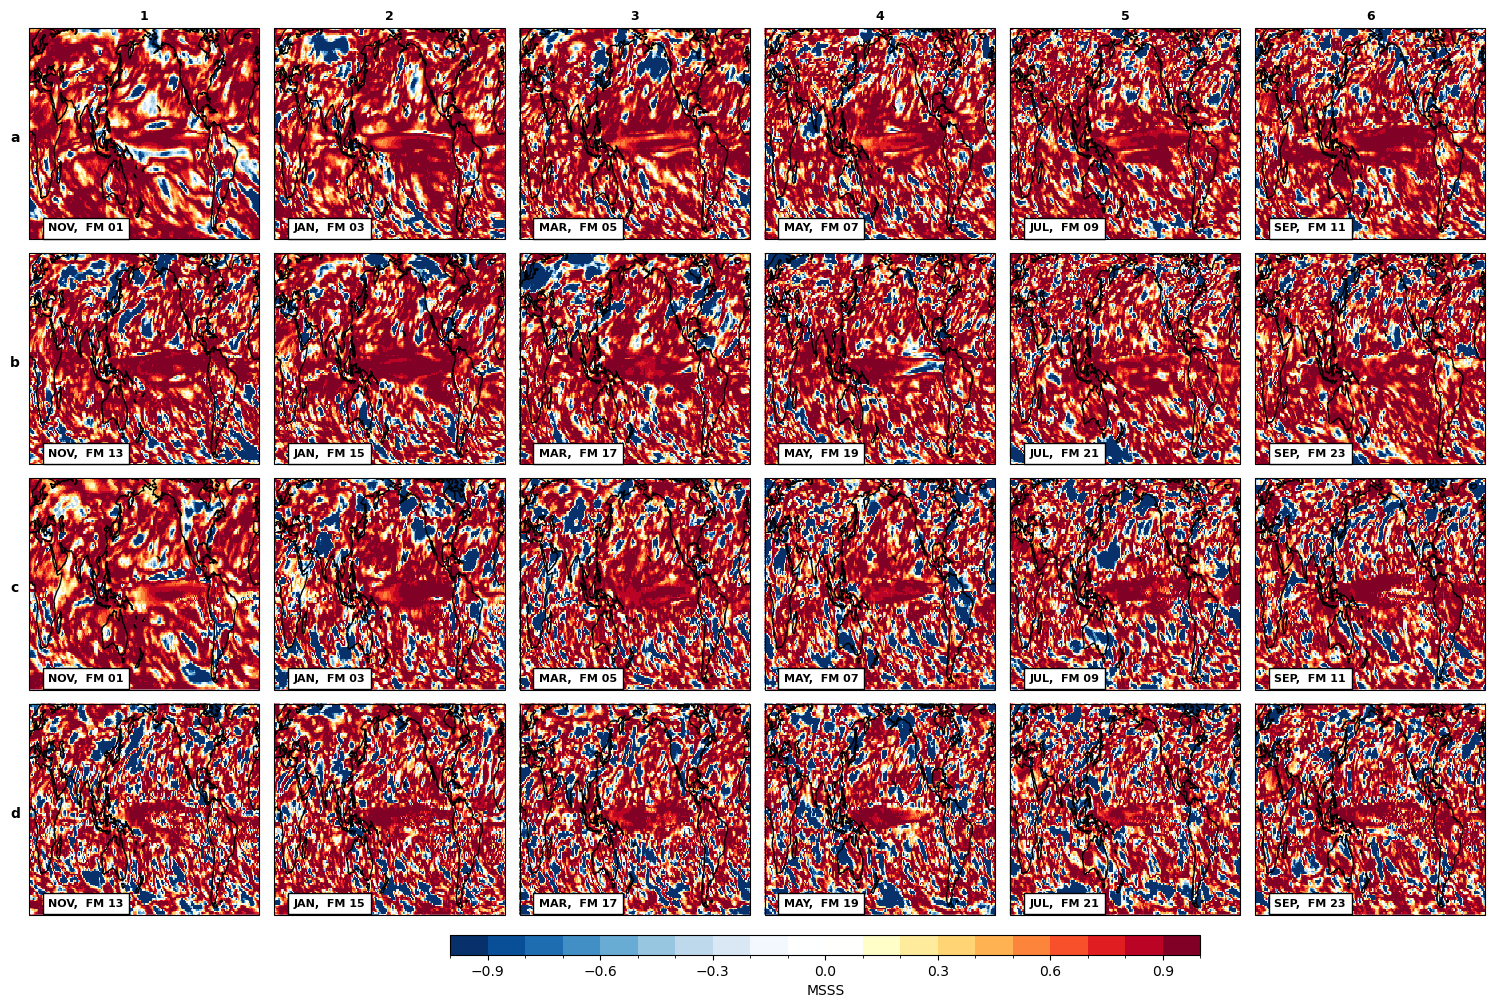

In [44]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss3['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss3['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp18.png')